In [155]:
import pandas as pd
import numpy as np
import networkx as nx
import re
import seaborn as sns
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
from collections import defaultdict


In [156]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

In [157]:
df_full.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


In [158]:
df_full.shape

(286561, 6)

In [159]:
df_full['LINK_SENTIMENT'].value_counts()

LINK_SENTIMENT
 1    265491
-1     21070
Name: count, dtype: int64

In [160]:
total = df_full['LINK_SENTIMENT'].count()
positive_neutral = df_full['LINK_SENTIMENT'].value_counts().get(1, 0)
positive_neutral_ratio = positive_neutral / total

print(f"Ratio of positive/neutral sentiments: {positive_neutral_ratio:.2%}")

Ratio of positive/neutral sentiments: 92.65%


In [161]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286561 entries, 0 to 286560
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   SOURCE_SUBREDDIT  286561 non-null  object
 1   TARGET_SUBREDDIT  286561 non-null  object
 2   POST_ID           286561 non-null  object
 3   TIMESTAMP         286561 non-null  object
 4   LINK_SENTIMENT    286561 non-null  int64 
 5   PROPERTIES        286561 non-null  object
dtypes: int64(1), object(5)
memory usage: 13.1+ MB


In [162]:
df_full.describe()

,LINK_SENTIMENT
count,286561.000000
mean,0.852946
std,0.522000
min,-1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [163]:
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]

source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)

# keep only rows where both source and target are political
df = df_full[source_is_political & target_is_political]

df.shape, len(political_subs)

((331, 6), 605)

In [164]:

regex = re.compile(r'(politic|trump|biden|democrat|republican|liberal|conservative|progressive|socialist|libertarian|election|vote|campaign|maga|antifa|obama|sanders|rights|justice|reform|policy|government|senate|president)', re.IGNORECASE)
dynamic_political_subs = [sub for sub in df_full["SOURCE_SUBREDDIT"].unique() if regex.search(sub)]
political_subs.extend(dynamic_political_subs)
political_subs = list(set(political_subs))

source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)
df = df_full[source_is_political & target_is_political]

df.shape, len(political_subs)

((2042, 6), 1074)

In [165]:
clustering_embed = pd.read_csv("data/embedding_clusters.csv")

df = df[df['SOURCE_SUBREDDIT'].isin(clustering_embed['subreddit']) &
                        df['TARGET_SUBREDDIT'].isin(clustering_embed['subreddit'])]

df

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
362,libertarian,conservative,1uf53xs,2014-01-04 14:41:05,1,"739.0,633.0,0.794316644114,0.00135317997294,0...."
547,communism101,communism,1ujok7s,2014-01-06 08:44:10,1,"608.0,525.0,0.792763157895,0.00164473684211,0...."
962,mensrightsmeta,mensrights,1urzs0s,2014-01-15 11:33:58,1,"559.0,471.0,0.75313059034,0.00357781753131,0.0..."
2200,politicaldiscussion,politics,1vgz6fs,2014-01-17 11:48:58,1,"582.0,499.0,0.790378006873,0.00687285223368,0...."
2256,communism101,socialism,1vi0kys,2014-01-17 13:25:07,1,"2073.0,1792.0,0.766039556199,0.0284611673903,0..."
...,...,...,...,...,...,...
285109,thedavidpakmanshow,socialism,67lc3us,2017-04-25 18:40:37,1,"1316.0,1103.0,0.807750759878,0.00227963525836,..."
285287,shitliberalssay,ukpolitics,67ptug,2017-04-26 10:39:02,-1,"238.0,220.0,0.773109243697,0.0168067226891,0.0..."
285825,enough_sanders_spam,enoughsandersspam,67zs07,2017-04-27 17:34:00,-1,"783.0,681.0,0.757343550447,0.0204342273308,0.0..."
285866,neoliberal,badeconomics,680xo6s,2017-04-27 21:36:40,1,"1506.0,1309.0,0.750332005312,0.0152722443559,0..."


In [166]:
to_drop = ['devotedmap', 'devoted', 'reformedhumor', 
           'reformed', 'mtaugustajustice', 
           'justiceleague', 'injustice',
           'antifa', 'enoughantifaspam',
            'mmt_economics', 'ronpaul',
            'liberalgunowners', 'guncontrol'
          ]
df = df.drop(df[df['SOURCE_SUBREDDIT'].isin(to_drop) | df['TARGET_SUBREDDIT'].isin(to_drop)].index)

df.shape

(1887, 6)

In [167]:
df

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
362,libertarian,conservative,1uf53xs,2014-01-04 14:41:05,1,"739.0,633.0,0.794316644114,0.00135317997294,0...."
547,communism101,communism,1ujok7s,2014-01-06 08:44:10,1,"608.0,525.0,0.792763157895,0.00164473684211,0...."
962,mensrightsmeta,mensrights,1urzs0s,2014-01-15 11:33:58,1,"559.0,471.0,0.75313059034,0.00357781753131,0.0..."
2200,politicaldiscussion,politics,1vgz6fs,2014-01-17 11:48:58,1,"582.0,499.0,0.790378006873,0.00687285223368,0...."
2256,communism101,socialism,1vi0kys,2014-01-17 13:25:07,1,"2073.0,1792.0,0.766039556199,0.0284611673903,0..."
...,...,...,...,...,...,...
285109,thedavidpakmanshow,socialism,67lc3us,2017-04-25 18:40:37,1,"1316.0,1103.0,0.807750759878,0.00227963525836,..."
285287,shitliberalssay,ukpolitics,67ptug,2017-04-26 10:39:02,-1,"238.0,220.0,0.773109243697,0.0168067226891,0.0..."
285825,enough_sanders_spam,enoughsandersspam,67zs07,2017-04-27 17:34:00,-1,"783.0,681.0,0.757343550447,0.0204342273308,0.0..."
285866,neoliberal,badeconomics,680xo6s,2017-04-27 21:36:40,1,"1506.0,1309.0,0.750332005312,0.0152722443559,0..."


In [168]:
df['LINK_SENTIMENT'].value_counts()

LINK_SENTIMENT
 1    1649
-1     238
Name: count, dtype: int64

In [169]:
total = df['LINK_SENTIMENT'].count()
positive_neutral = df['LINK_SENTIMENT'].value_counts().get(1, 0)
positive_neutral_ratio = positive_neutral / total

print(f"Ratio of positive/neutral sentiments: {positive_neutral_ratio:.2%}")

Ratio of positive/neutral sentiments: 87.39%


In [170]:
df_full['TIMESTAMP'] = pd.to_datetime(df_full['TIMESTAMP'])
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

<Axes: title={'center': 'Monthly Average Sentiment of All Subreddits'}, xlabel='TIMESTAMP'>

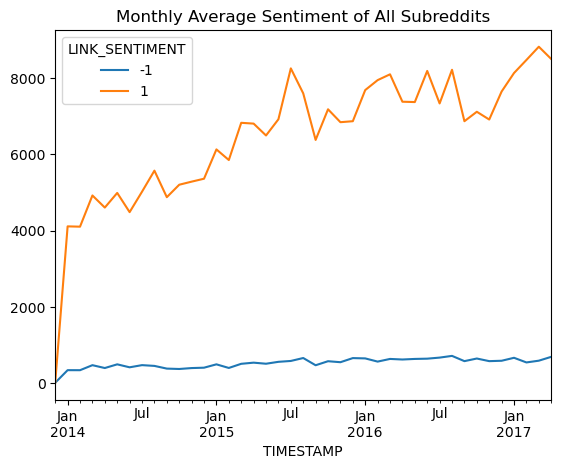

In [171]:
df_full.groupby([df_full['TIMESTAMP'].dt.to_period('M'), 'LINK_SENTIMENT']).size().unstack().plot(title="Monthly Average Sentiment of All Subreddits")

<Axes: title={'center': 'Monthly Average Sentiment of Political Subreddits'}, xlabel='TIMESTAMP'>

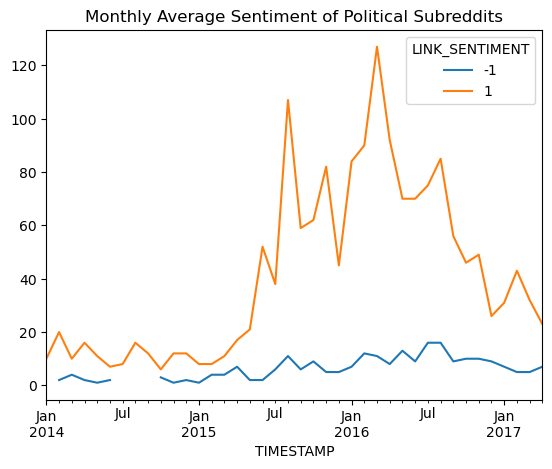

In [172]:
df.groupby([df['TIMESTAMP'].dt.to_period('M'), 'LINK_SENTIMENT']).size().unstack().plot(title="Monthly Average Sentiment of Political Subreddits")

In [178]:
df.groupby([df['TIMESTAMP'].dt.to_period('M'), 'LINK_SENTIMENT']).size().unstack()

LINK_SENTIMENT,-1,1
TIMESTAMP,,
2014-01,NaN,10.0
2014-02,2.0,20.0
2014-03,4.0,10.0
2014-04,2.0,16.0
2014-05,1.0,11.0
2014-06,2.0,7.0
2014-07,NaN,8.0
2014-08,5.0,16.0
2014-09,NaN,12.0


In [173]:
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# create graph
G = nx.from_pandas_edgelist(edgelist_df, source=source, target=target, create_using=nx.DiGraph(),edge_attr="count")


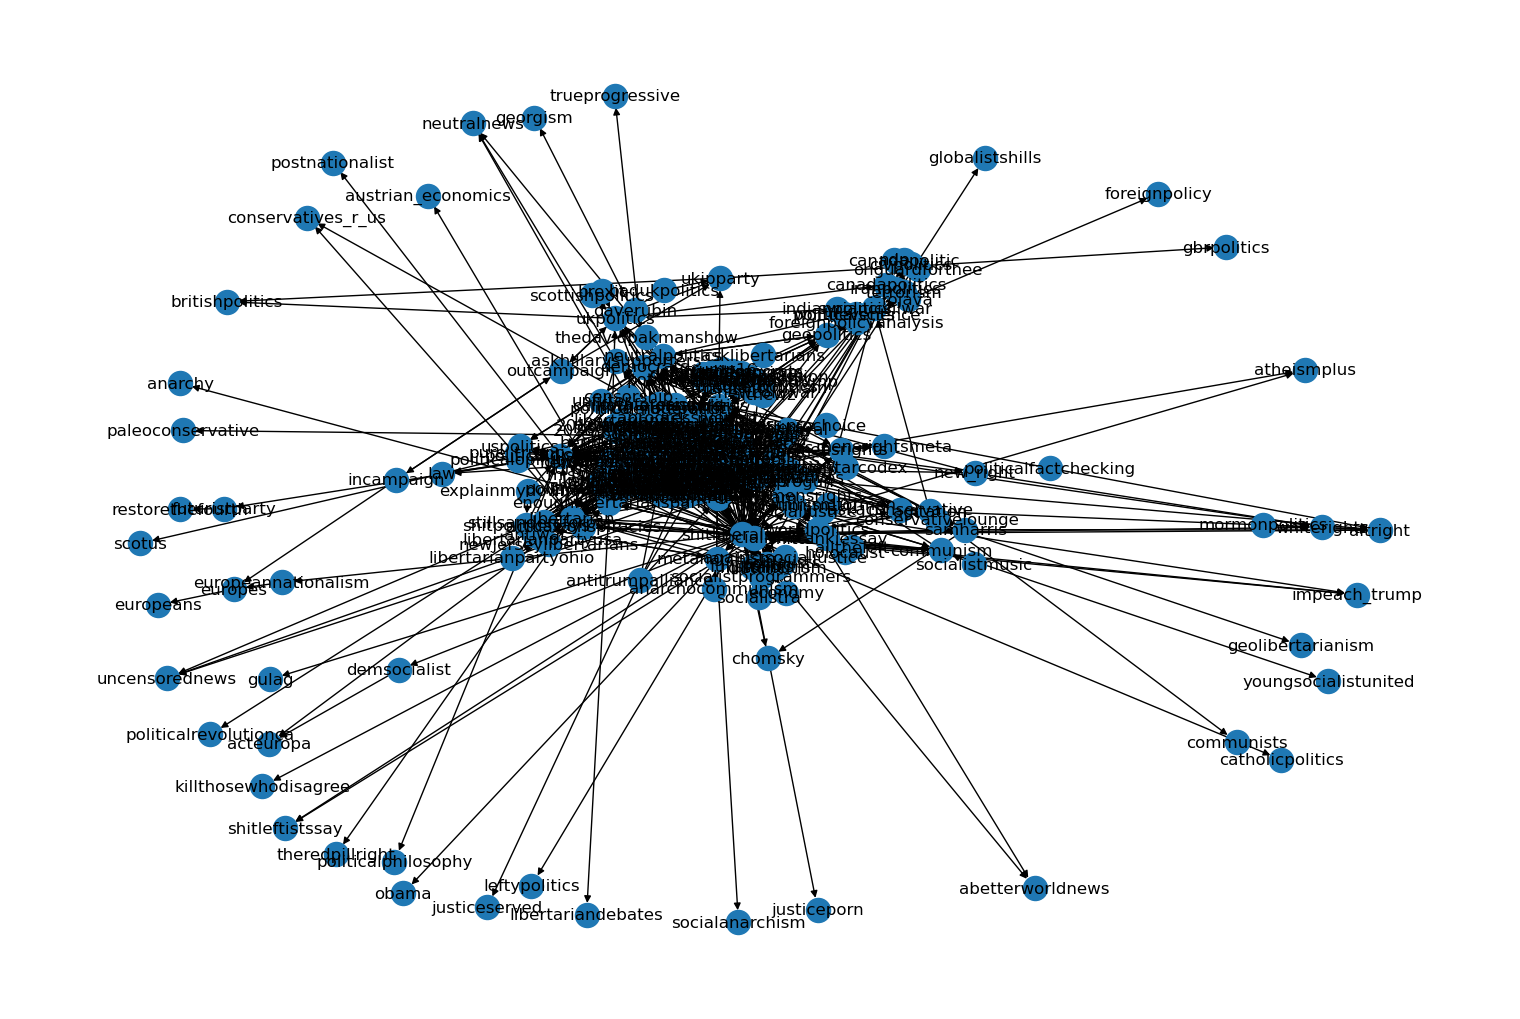

In [174]:
plt.figure(figsize=(15,10))
nx.draw(G, with_labels=True)
plt.show()

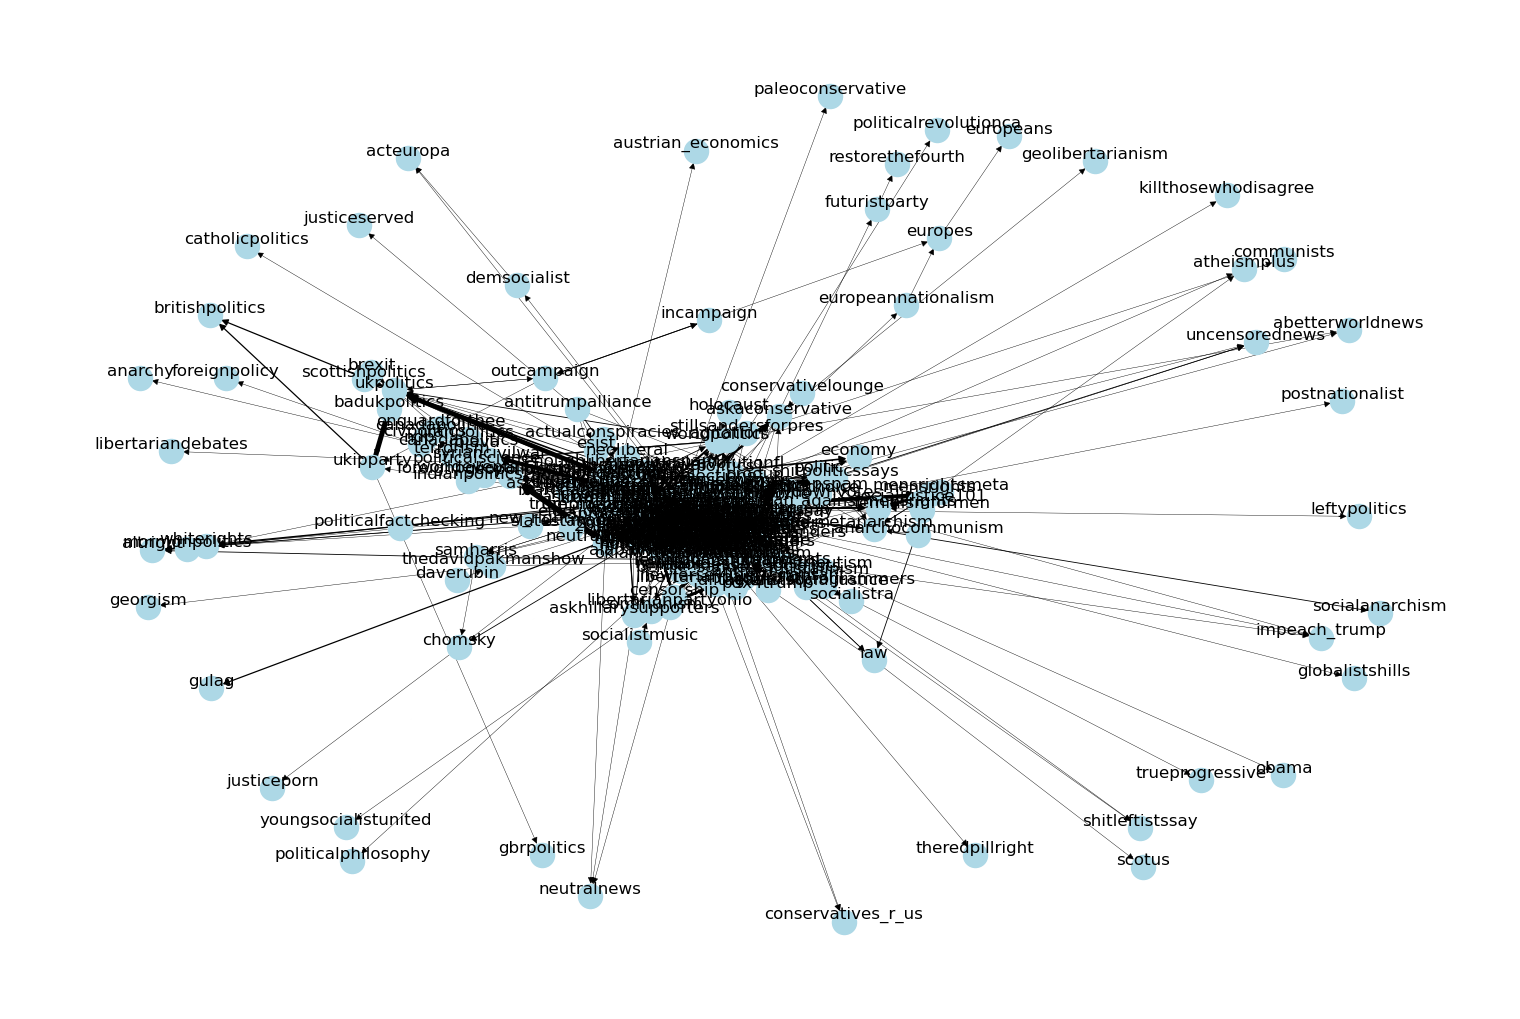

In [175]:
edgelist_df = df.groupby(["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT"]).size().reset_index(name="weight")

# Create graph
G = nx.from_pandas_edgelist(
    edgelist_df,
    source="SOURCE_SUBREDDIT",
    target="TARGET_SUBREDDIT",
    edge_attr="weight",
    create_using=nx.DiGraph(),
)

# Positioning for nodes
pos = nx.spring_layout(G)

# Draw nodes and edges with edge weights as thickness
plt.figure(figsize=(15, 10))
nx.draw(
    G,
    pos,
    with_labels=False,  # Disable default labels
    node_color="lightblue",
    arrowsize=10,
    width=[d["weight"] * 0.3 for (u, v, d) in G.edges(data=True)],  # Scale edge width by weight
)

# Add labels with an offset
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(
    G,
    pos,
    labels=labels,
    font_size=12,
    font_color="black",
    verticalalignment="bottom",  # Adjust label position
    horizontalalignment="center",
)

plt.show()

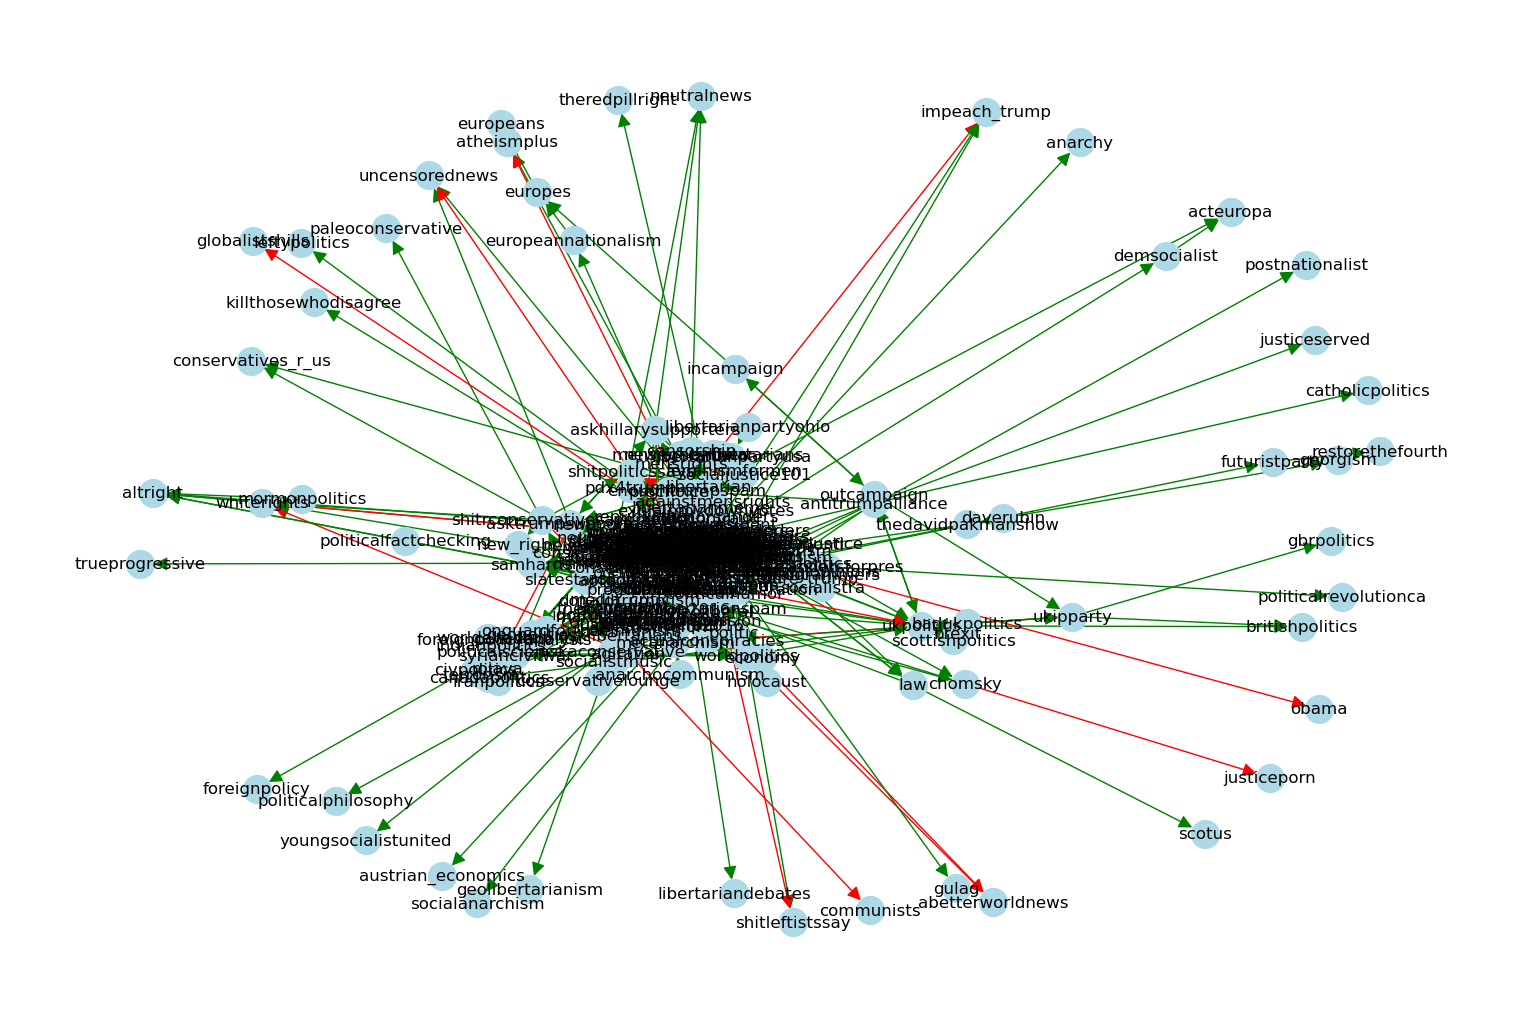

In [176]:
# Create the graph
edgelist_df = df.groupby(["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT", "LINK_SENTIMENT"]).size().reset_index(name="weight")

G = nx.from_pandas_edgelist(
    edgelist_df,
    source="SOURCE_SUBREDDIT",
    target="TARGET_SUBREDDIT",
    edge_attr=["weight", "LINK_SENTIMENT"],
    create_using=nx.DiGraph(),
)
edge_colors = [
    "green" if d["LINK_SENTIMENT"] > 0 else "red" for (u, v, d) in G.edges(data=True)
]

# Positioning for nodes
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(15, 10))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    edge_color=edge_colors,  # Use edge color mapping
    arrowsize=20,
    node_size=400,  # Adjust node size as needed
)

plt.show()

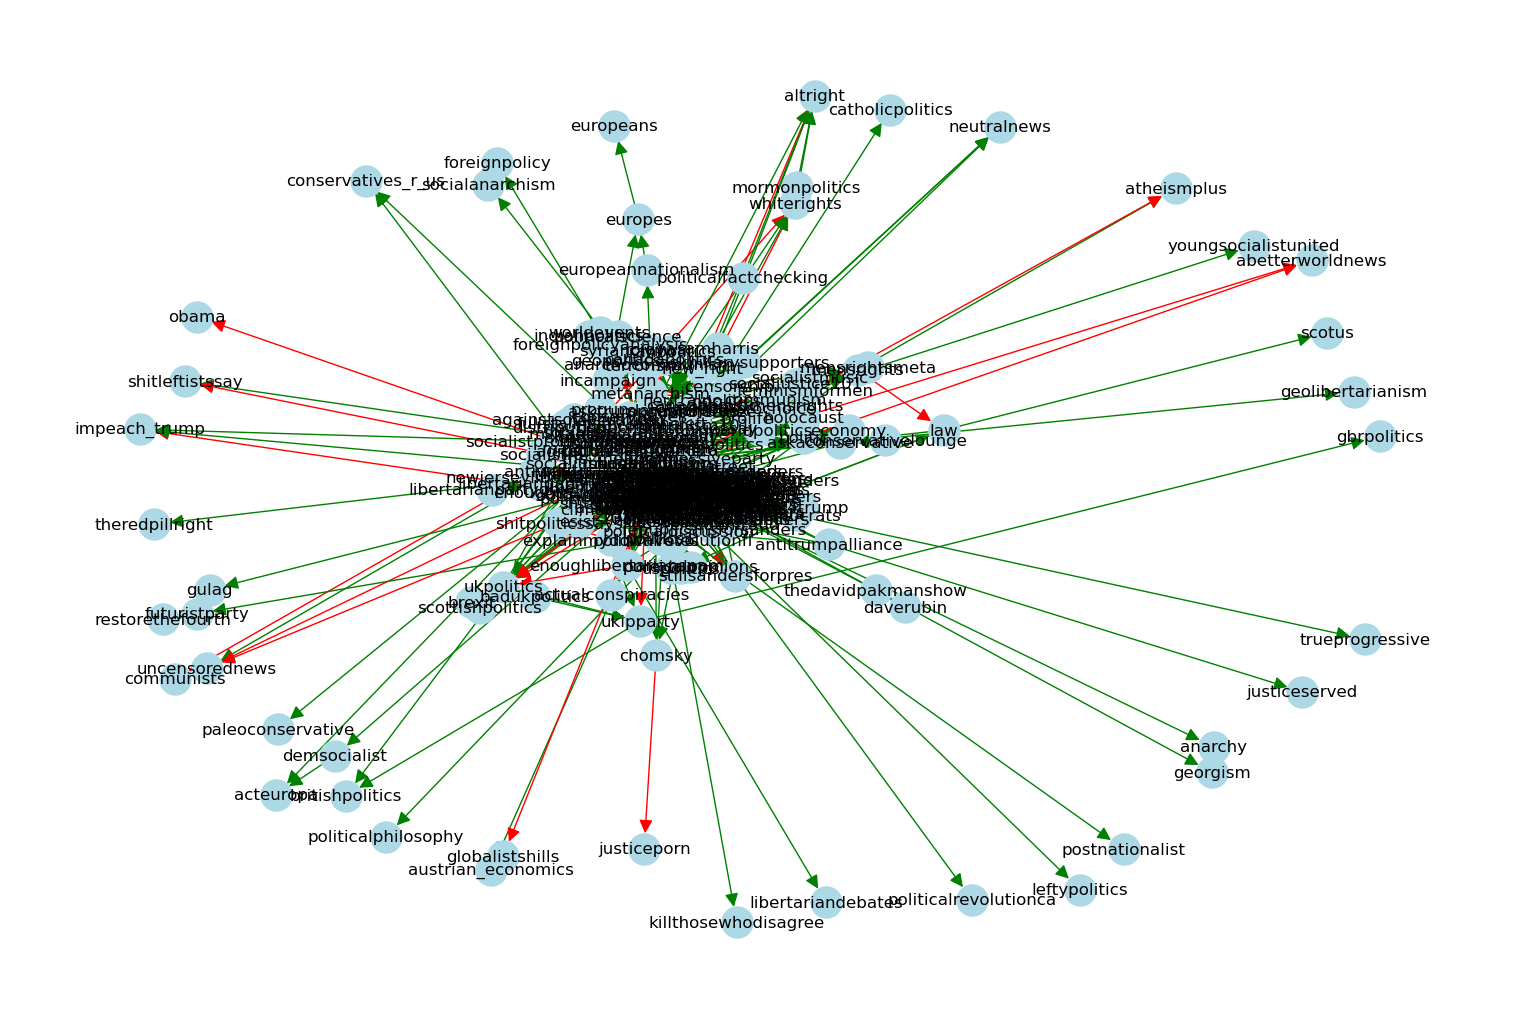

In [177]:
# Aggregate weights and average sentiment for each subreddit pair
edgelist_df = df.groupby(["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT"], as_index=False).agg(
    weight=("POST_ID", "size"),  # Count of connections
    avg_sentiment=("LINK_SENTIMENT", "mean"),  # Average sentiment
)

# Create the graph
G = nx.from_pandas_edgelist(
    edgelist_df,
    source="SOURCE_SUBREDDIT",
    target="TARGET_SUBREDDIT",
    edge_attr=["weight", "avg_sentiment"],
    create_using=nx.DiGraph(),
)

# Map average sentiment to colors
edge_colors = [
    "green" if d["avg_sentiment"] > 0 else "red" for (u, v, d) in G.edges(data=True)
]

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(15, 10))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    edge_color=edge_colors,
    arrowsize=20,
    node_size=500,
)
plt.show()